Purpose:

Predict if credit is "Good" or "Bad"

Business related questions:

- What are some of the features that people with "Good" credit have?
- What is the average age of applicants?
- What is the average amount people have in their checking and savings account?
- What is the most common property type?
- what is the most common sex/status with "Good" credit
- Does an applicant's demographics cause a deviation in the predicted category vs. what category they were actually placed in thus suggesting bias?



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('german.data', sep='\s+')
df.head(2)

,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1.1
0,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
1,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1


In [3]:
column_names = ['checking_account', 'duration_month', 'credit_history', 'credit_purpose','credit_amount','savings_account','present_employment','disposable_income_percent',
 'status_sex','debtors','residence_since','property','age','other_installments', 'housing','credits_at_current_bank','job','dependants','telephone', 'foreign_worker','class']

In [4]:
df.columns = column_names
df.head(2)

,checking_account,duration_month,credit_history,credit_purpose,credit_amount,savings_account,present_employment,disposable_income_percent,status_sex,debtors,...,property,age,other_installments,housing,credits_at_current_bank,job,dependants,telephone,foreign_worker,class
0,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
1,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   checking_account           999 non-null    object
 1   duration_month             999 non-null    int64 
 2   credit_history             999 non-null    object
 3   credit_purpose             999 non-null    object
 4   credit_amount              999 non-null    int64 
 5   savings_account            999 non-null    object
 6   present_employment         999 non-null    object
 7   disposable_income_percent  999 non-null    int64 
 8   status_sex                 999 non-null    object
 9   debtors                    999 non-null    object
 10  residence_since            999 non-null    int64 
 11  property                   999 non-null    object
 12  age                        999 non-null    int64 
 13  other_installments         999 non-null    object
 14  housing   

In [6]:
df.describe()

,duration_month,credit_amount,disposable_income_percent,residence_since,age,credits_at_current_bank,dependants,class
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,20.917918,3273.362362,2.971972,2.843844,35.514515,1.406406,1.155155,1.300300
std,12.055619,2823.365811,1.118802,1.103665,11.337487,0.577639,0.362234,0.458618
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1368.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2320.000000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.500000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


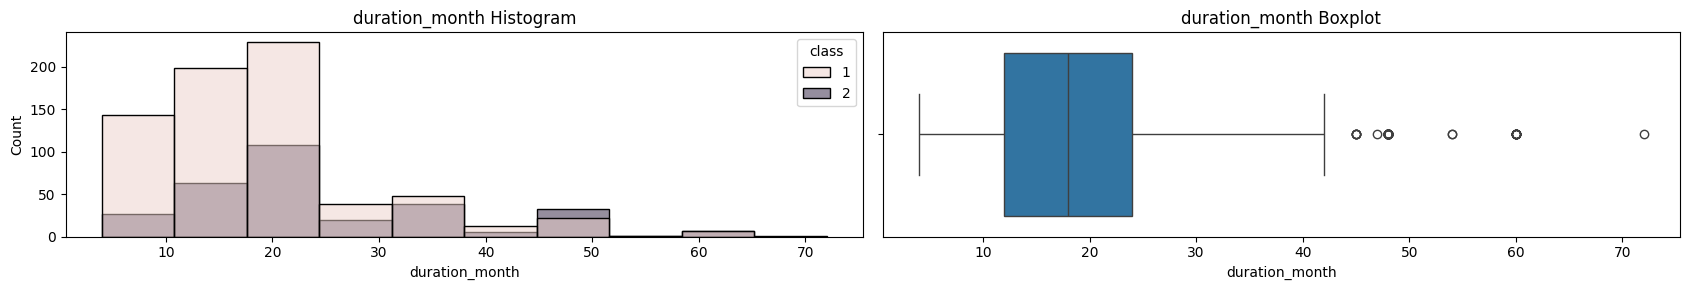

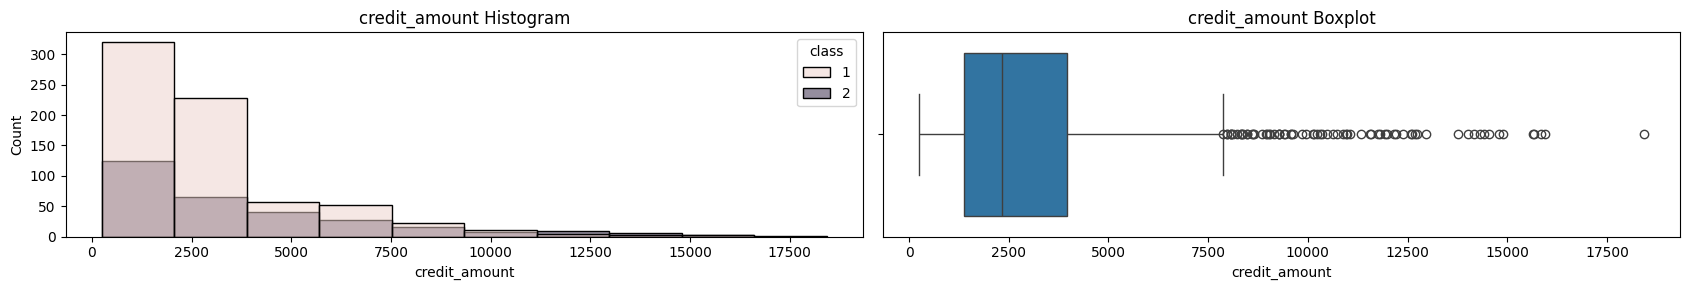

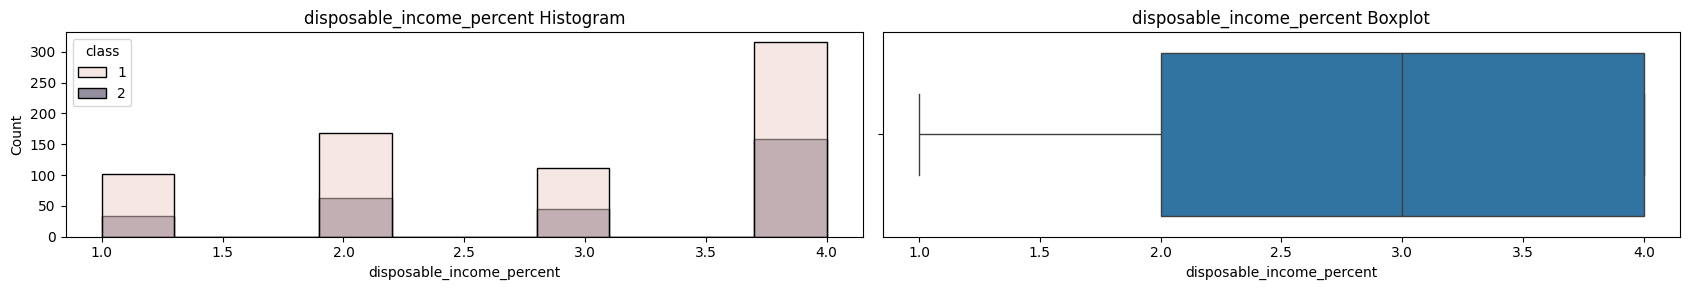

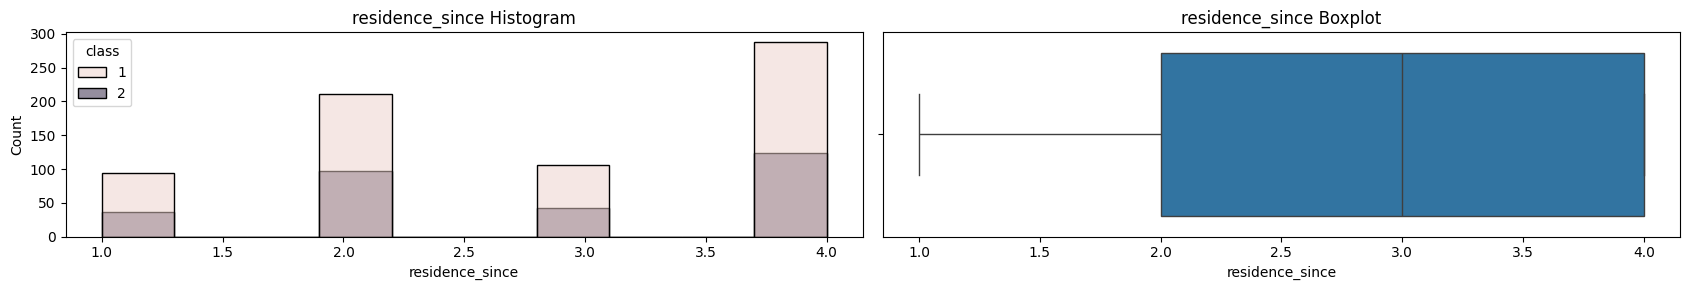

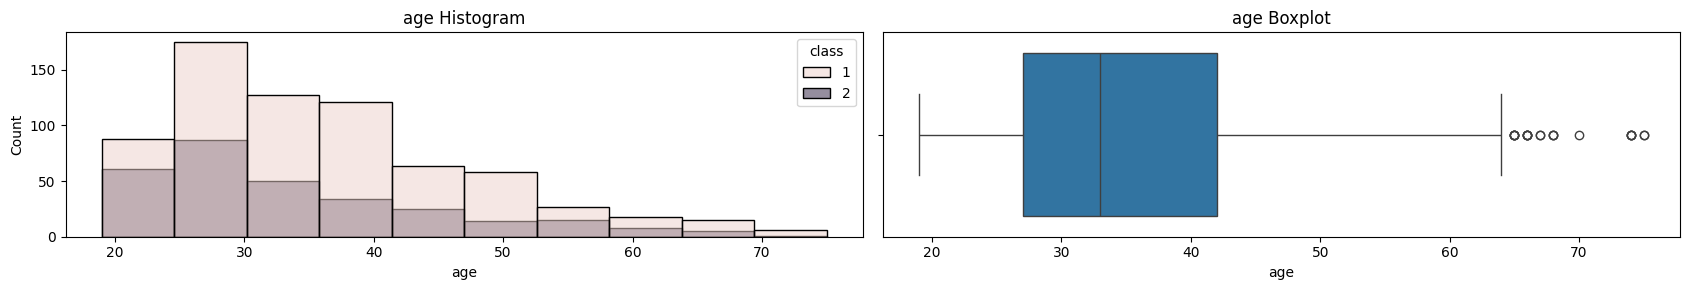

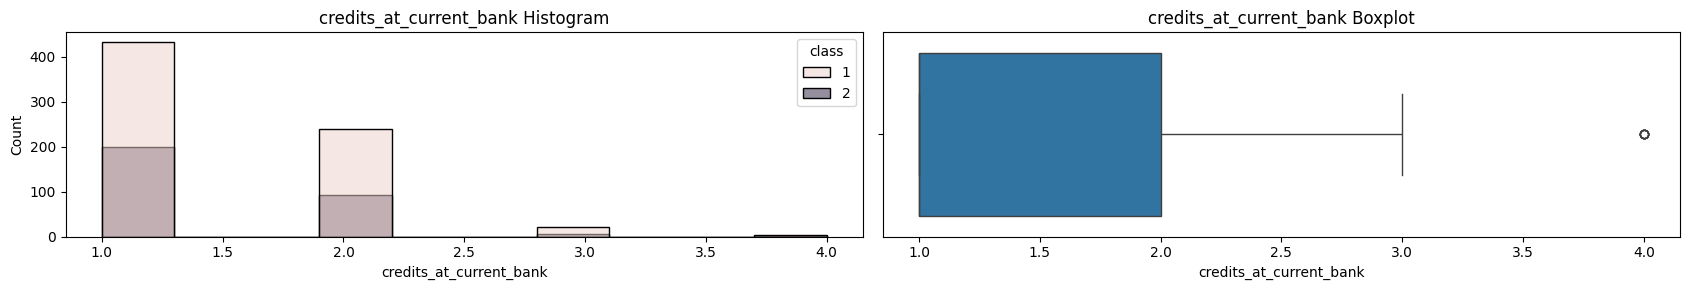

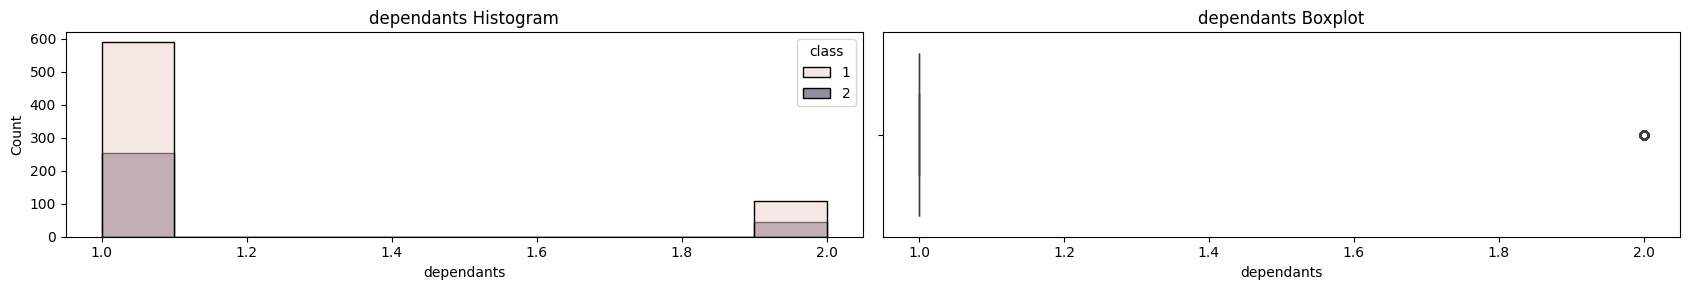

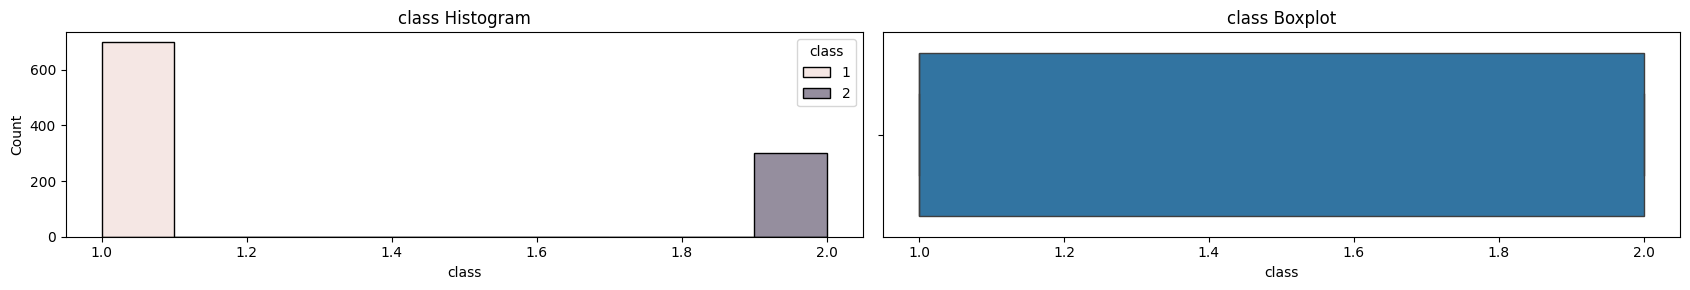

In [7]:
for i in df.columns:
    if df[i].dtype == 'int64':
        fig, ax = plt.subplots(1, 2, figsize=(17, 3))

        sns.histplot(data=df, x=i, bins=10, ax=ax[0], hue='class')
        ax[0].set_title(f'{i} Histogram')
      

        sns.boxplot(data=df, x=i, ax=ax[1])
        ax[1].set_title(f'{i} Boxplot')
   
        plt.tight_layout()
        plt.show();

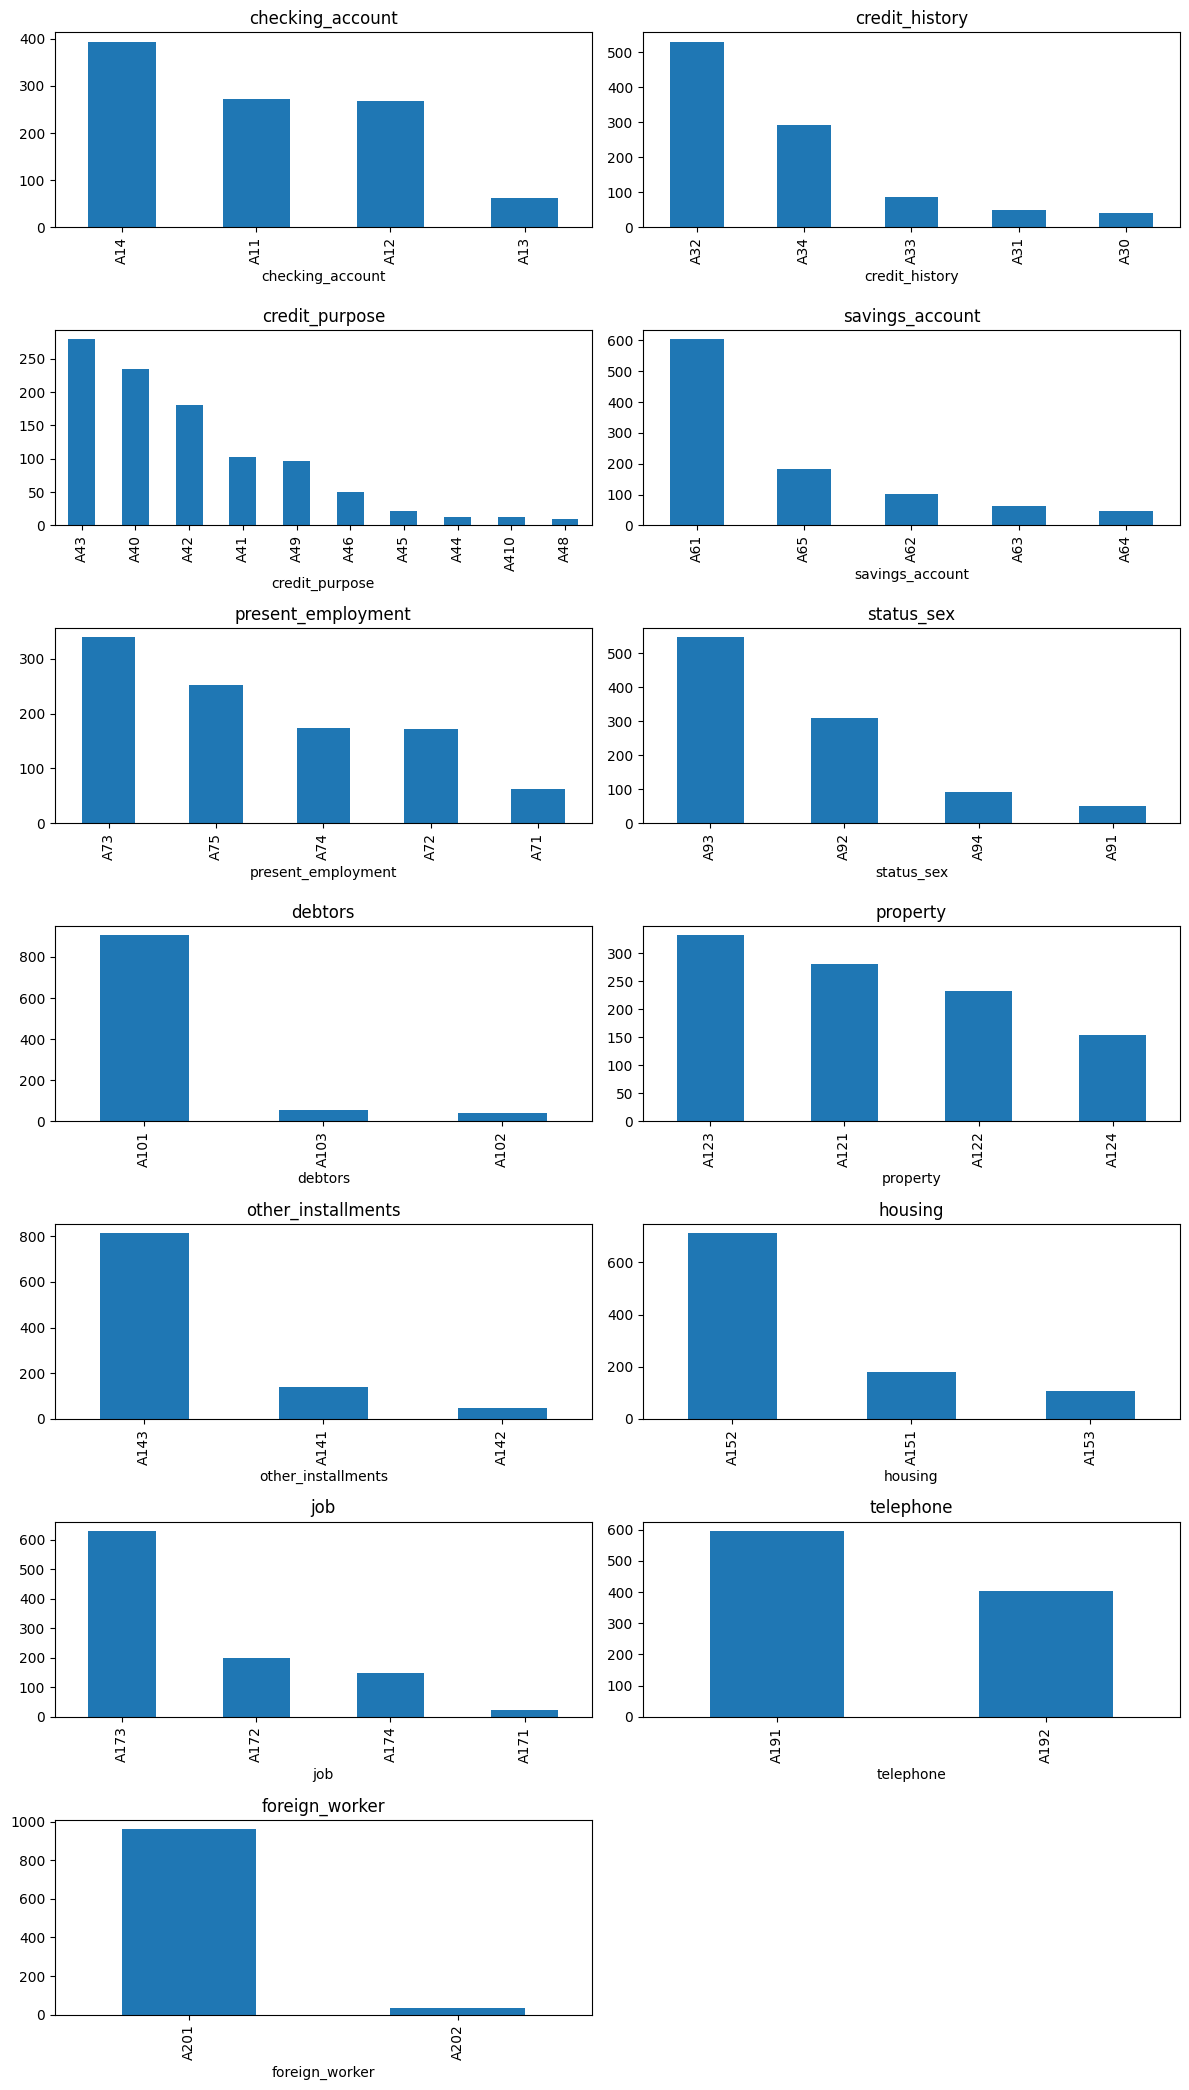

In [8]:
object_columns = df.select_dtypes(include='object').columns

num_rows = (len(object_columns) + 1) // 2  

fig, axes = plt.subplots(num_rows, 2, figsize=(12, 3*num_rows))

axes = axes.flatten()

for i, col in enumerate(object_columns):
    df[col].value_counts().plot(kind='bar', ax=axes[i],)
    axes[i].set_title(col)

for i in range(len(object_columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

<Axes: >

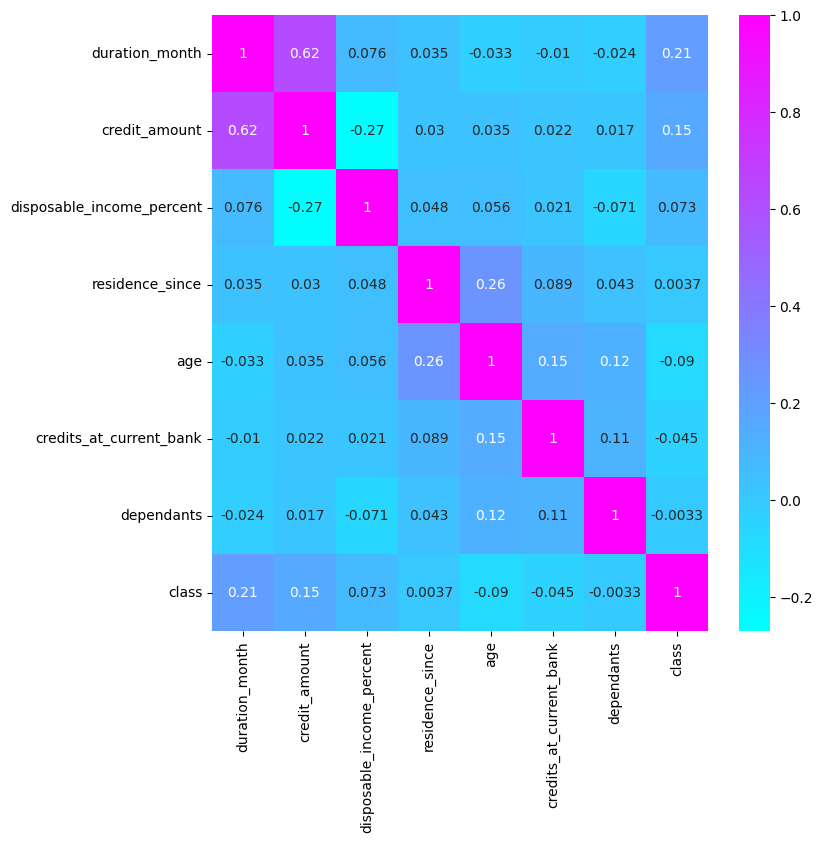

In [9]:
corr_matr = df.corr(numeric_only=True)
plt.figure(figsize=(8,8))
sns.heatmap(corr_matr, cmap= 'cool', annot= True)

### Analayzing Good vs Bad Credit

In [10]:
bad_credit = df[df['class'] == 2]
good_credit = df[df['class'] == 1]

In [11]:
bad_credit.groupby('credits_at_current_bank').mean(numeric_only = True)

,duration_month,credit_amount,disposable_income_percent,residence_since,age,dependants,class
credits_at_current_bank,,,,,,,
1,24.335000,3751.870000,3.150000,2.770000,33.250000,1.135000,2.0
2,26.076087,4313.076087,3.032609,2.956522,35.054348,1.184783,2.0
3,24.000000,4204.000000,2.333333,3.500000,40.833333,1.333333,2.0
4,24.000000,4518.500000,3.000000,4.000000,34.500000,1.000000,2.0


In [12]:
good_credit.groupby('credits_at_current_bank').mean(numeric_only = True)

,duration_month,credit_amount,disposable_income_percent,residence_since,age,dependants,class
credits_at_current_bank,,,,,,,
1,19.166282,2963.034642,2.856813,2.806005,35.247113,1.129330,1.0
2,19.858333,3043.820833,3.029167,2.850000,36.716667,1.179167,1.0
3,13.454545,3008.772727,2.727273,3.272727,45.545455,1.363636,1.0
4,19.500000,2236.750000,4.000000,3.750000,53.500000,1.500000,1.0


***Observations:***
- The **average credit amount** in people with bad credit tends to me more in general in comparison to people with good credit. In other words, bad credit has more accounts open and ask for more money
- The **average age** of people with 4 or more credit accounts in the current bank is 53 years old with good credit and 34.5 years old with bad credit 
- We can drop the dependants and residence_since. These features are very similar between people with good and bad credit. 


In [13]:
df = df.drop(columns=['dependants', 'residence_since'], axis= 1)

In [14]:
print(f'Good credit:\n{good_credit.checking_account.value_counts()}')
print(f'Bad Credit:\n{bad_credit.checking_account.value_counts()}')

Good credit:
checking_account
A14    348
A12    164
A11    138
A13     49
Name: count, dtype: int64
Bad Credit:
checking_account
A11    135
A12    105
A14     46
A13     14
Name: count, dtype: int64


***Observations:***
- People with good credit do not have checking account at the current bank, while people wioth bad credit have more accoutns open
- For the people that do have an account open, people with good credit have more than 200 DM in their account

***Maybe We should consider using one-hot encoding on checking account***

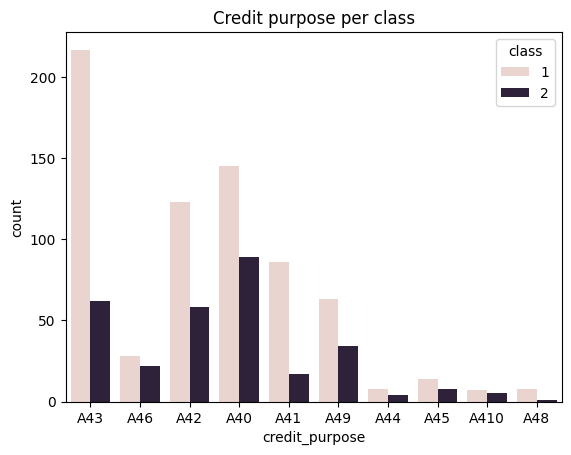

In [15]:
sns.countplot(x ='credit_purpose',hue='class', data= df)
plt.title('Credit purpose per class')
plt.show();

Attribute 4:  (qualitative)
	      Purpose
	      A40 : car (new)
	      A41 : car (used)
	      A42 : furniture/equipment
	      A43 : radio/television
	      A44 : domestic appliances
	      A45 : repairs
	      A46 : education
	      A47 : (vacation - does not exist?)
	      A48 : retraining
	      A49 : business
	      A410 : others


***Observations:***
- Class 1(good) use their credit for radio and televisions, while people with bad credit tend to use their credit mostly for purchasing a car. Another interesiting fact is that people with good credit tend to use their credit for business purposes.

***We should use one-hot encoding for credit purpose***

In [16]:
code_to_name = {
    'A40': 'NewCar',
    'A41': 'UsedCar',
    'A42': 'FurnitureEquipment',
    'A43': 'RadioTelevision',
    'A44': 'DomesticAppliance',
    'A45': 'Repairs',
    'A46': 'Education',
    'A48': 'Vacation',
    'A49': 'Retraining',
    'A410': 'Business'
}
df['credit_purpose'] = df['credit_purpose'].map(code_to_name)

In [17]:
credit_purpose_dummies = pd.get_dummies(df['credit_purpose'])
df = df.drop('credit_purpose', axis=1)
df_encoded = pd.concat([df, credit_purpose_dummies], axis=1)
df_encoded.columns 

Index(['checking_account', 'duration_month', 'credit_history', 'credit_amount',
       'savings_account', 'present_employment', 'disposable_income_percent',
       'status_sex', 'debtors', 'property', 'age', 'other_installments',
       'housing', 'credits_at_current_bank', 'job', 'telephone',
       'foreign_worker', 'class', 'Business', 'DomesticAppliance', 'Education',
       'FurnitureEquipment', 'NewCar', 'RadioTelevision', 'Repairs',
       'Retraining', 'UsedCar', 'Vacation'],
      dtype='object')

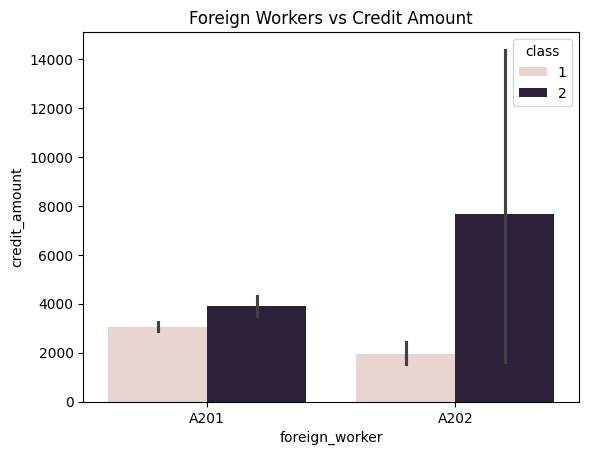

In [18]:
sns.barplot(x = 'foreign_worker', y ='credit_amount', data = df,  hue='class')
plt.title('Foreign Workers vs Credit Amount')
plt.show()

foreign worker:

A201 : yes

A202 : no

***Observations:***
- Foreign workers, tend to ask higher amnounts of credit and tend to have a population with higher bad credit history

**Since Foreign workers tend to have bad credit we shuold encode this categorical variable***

In [19]:
df_encoded = pd.get_dummies(df_encoded, columns=['foreign_worker'], drop_first=True, prefix='Foreign') # Dropping Foreign Column to Avoid Multicolinearity
df_encoded = df_encoded.drop('Foreign_A202', axis=1)

In [20]:
df_encoded.columns

Index(['checking_account', 'duration_month', 'credit_history', 'credit_amount',
       'savings_account', 'present_employment', 'disposable_income_percent',
       'status_sex', 'debtors', 'property', 'age', 'other_installments',
       'housing', 'credits_at_current_bank', 'job', 'telephone', 'class',
       'Business', 'DomesticAppliance', 'Education', 'FurnitureEquipment',
       'NewCar', 'RadioTelevision', 'Repairs', 'Retraining', 'UsedCar',
       'Vacation'],
      dtype='object')

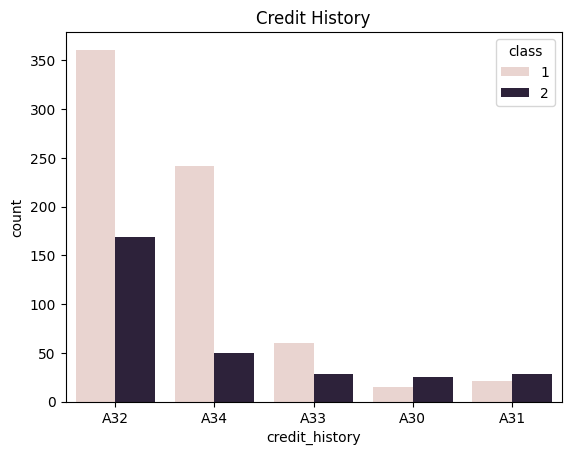

In [21]:
sns.countplot(x = 'credit_history', data=df, hue ='class')
plt.title('Credit History')
plt.show();

Credit history

	A30 : No debt
          
    A31 : All debt paid off at applying bank

    A32 : On time payments
          
    A33 : Late payments
      
    A34 : Red Flag Accounts

***Observations:***
- Although the majority of people with good and bad credit tend to pay off all their debt. There is a significant amount of people with bad debt that have accounts classified as critical in other banks. This could mean that they are looking to get more credit with bad history in other banks


In [22]:
df.columns

Index(['checking_account', 'duration_month', 'credit_history', 'credit_amount',
       'savings_account', 'present_employment', 'disposable_income_percent',
       'status_sex', 'debtors', 'property', 'age', 'other_installments',
       'housing', 'credits_at_current_bank', 'job', 'telephone',
       'foreign_worker', 'class'],
      dtype='object')

In [23]:
df_encoded = pd.get_dummies(df_encoded, columns=['credit_history'], prefix='credit_history') # Dropping Foreign Column to Avoid Multicolinearity

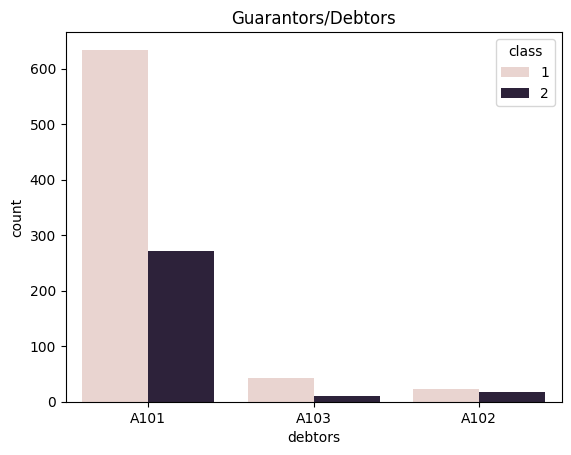

In [24]:
sns.countplot(data=df, x='debtors', hue='class')
plt.title('Guarantors/Debtors')
plt.show()

Other debtors / guarantors

	      A101 : none

	      A102 : co-applicant

	      A103 : guarantor

***We can eliminate this column***

In [25]:
df_encoded = df_encoded.drop(columns= 'debtors', axis=1)

In [26]:
rename_dict = {
    'credit_history_A30': 'No_debt',
    'credit_history_A31': 'All_debt_paid_off_at_applying_bank',
    'credit_history_A32': 'On_time_payments',
    'credit_history_A33': 'Late_payments',
    'credit_history_A34': 'Red_Flag_Accounts'
}

df_encoded = df_encoded.rename(columns=rename_dict)
df_encoded.columns

Index(['checking_account', 'duration_month', 'credit_amount',
       'savings_account', 'present_employment', 'disposable_income_percent',
       'status_sex', 'property', 'age', 'other_installments', 'housing',
       'credits_at_current_bank', 'job', 'telephone', 'class', 'Business',
       'DomesticAppliance', 'Education', 'FurnitureEquipment', 'NewCar',
       'RadioTelevision', 'Repairs', 'Retraining', 'UsedCar', 'Vacation',
       'No_debt', 'All_debt_paid_off_at_applying_bank', 'On_time_payments',
       'Late_payments', 'Red_Flag_Accounts'],
      dtype='object')

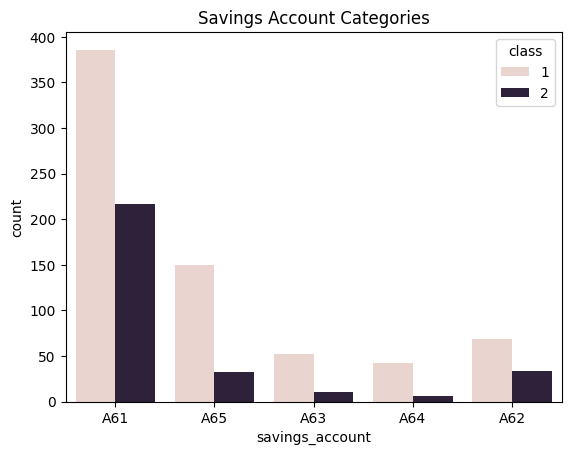

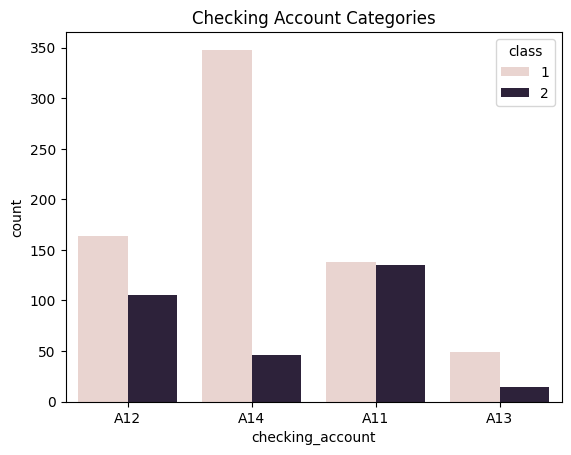

In [27]:
sns.countplot(data = df , x = df['savings_account'], hue='class')
plt.title('Savings Account Categories')
plt.show();
sns.countplot(data = df , x = df['checking_account'], hue='class')
plt.title('Checking Account Categories')
plt.show();

		checking account
		
        A11 :      ... <    0 DM

	    A12 : 0 <= ... <  200 DM

	    A13 :      ... >= 200 DM /
		salary assignments for at least 1 year
		
        A14 : no checking account

  Savings account/bonds

	      A61 :          ... <  100 DM

	      A62 :   100 <= ... <  500 DM

	      A63 :   500 <= ... < 1000 DM

	      A64 :          .. >= 1000 DM
		  
              A65 :   unknown/ no savings account

**We can eliminate the checking and savings account feature. The majority of the people do not have an account at the bank or they have less than 100 DM**

In [28]:
df_encoded = df_encoded.drop(columns=['checking_account', 'savings_account'], axis =1 )
df_encoded.columns

Index(['duration_month', 'credit_amount', 'present_employment',
       'disposable_income_percent', 'status_sex', 'property', 'age',
       'other_installments', 'housing', 'credits_at_current_bank', 'job',
       'telephone', 'class', 'Business', 'DomesticAppliance', 'Education',
       'FurnitureEquipment', 'NewCar', 'RadioTelevision', 'Repairs',
       'Retraining', 'UsedCar', 'Vacation', 'No_debt',
       'All_debt_paid_off_at_applying_bank', 'On_time_payments',
       'Late_payments', 'Red_Flag_Accounts'],
      dtype='object')

In [29]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 28 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   duration_month                      999 non-null    int64 
 1   credit_amount                       999 non-null    int64 
 2   present_employment                  999 non-null    object
 3   disposable_income_percent           999 non-null    int64 
 4   status_sex                          999 non-null    object
 5   property                            999 non-null    object
 6   age                                 999 non-null    int64 
 7   other_installments                  999 non-null    object
 8   housing                             999 non-null    object
 9   credits_at_current_bank             999 non-null    int64 
 10  job                                 999 non-null    object
 11  telephone                           999 non-null    object

***Dropping telephone***

In [30]:
df_encoded = df_encoded.drop(columns='telephone' , axis= 1)

In [31]:
df_encoded.groupby('class')['credits_at_current_bank'].value_counts()

class  credits_at_current_bank
1      1                          433
       2                          240
       3                           22
       4                            4
2      1                          200
       2                           92
       3                            6
       4                            2
Name: count, dtype: int64

In [32]:
df['class'].value_counts()

class
1    699
2    300
Name: count, dtype: int64

In [33]:
df_encoded = pd.get_dummies(df_encoded, columns=['credits_at_current_bank'], prefix='current_bank_credit') 

rename_dict = {
    'current_bank_credit_1': 'Great_Credit',
    'current_bank_credit_2': 'Good_Credit',
    'current_bank_credit_3': 'Ok_Credit',
    'current_bank_credit_4': 'Bad_Credit'
}
df_encoded = df_encoded.rename(columns=rename_dict)

df_encoded.columns

Index(['duration_month', 'credit_amount', 'present_employment',
       'disposable_income_percent', 'status_sex', 'property', 'age',
       'other_installments', 'housing', 'job', 'class', 'Business',
       'DomesticAppliance', 'Education', 'FurnitureEquipment', 'NewCar',
       'RadioTelevision', 'Repairs', 'Retraining', 'UsedCar', 'Vacation',
       'No_debt', 'All_debt_paid_off_at_applying_bank', 'On_time_payments',
       'Late_payments', 'Red_Flag_Accounts', 'Great_Credit', 'Good_Credit',
       'Ok_Credit', 'Bad_Credit'],
      dtype='object')

***Double of the amount of people with good credit have only one account open at the current bank in comparison to people with bad credit***

<Axes: xlabel='housing', ylabel='count'>

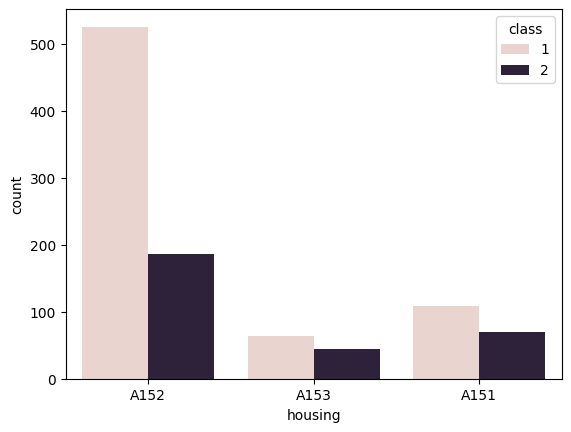

In [34]:
sns.countplot(data=df_encoded, x = 'housing', hue='class')

	      Housing
	      A151 : rent
	      A152 : own
	      A153 : for free

***Owning a home is an important factor for credit approval and usully homeowners need to have a 'decent' credit to own a home***

In [35]:
df_encoded = pd.get_dummies(df_encoded, columns=['housing'], prefix='housing') 

rename_dict = {
    'housing_A151': 'Rent',
    'housing_A152': 'Own',
    'housing_A153': 'For_Free'
}
df_encoded = df_encoded.rename(columns=rename_dict)

df_encoded.columns

Index(['duration_month', 'credit_amount', 'present_employment',
       'disposable_income_percent', 'status_sex', 'property', 'age',
       'other_installments', 'job', 'class', 'Business', 'DomesticAppliance',
       'Education', 'FurnitureEquipment', 'NewCar', 'RadioTelevision',
       'Repairs', 'Retraining', 'UsedCar', 'Vacation', 'No_debt',
       'All_debt_paid_off_at_applying_bank', 'On_time_payments',
       'Late_payments', 'Red_Flag_Accounts', 'Great_Credit', 'Good_Credit',
       'Ok_Credit', 'Bad_Credit', 'Rent', 'Own', 'For_Free'],
      dtype='object')

<Axes: xlabel='job', ylabel='count'>

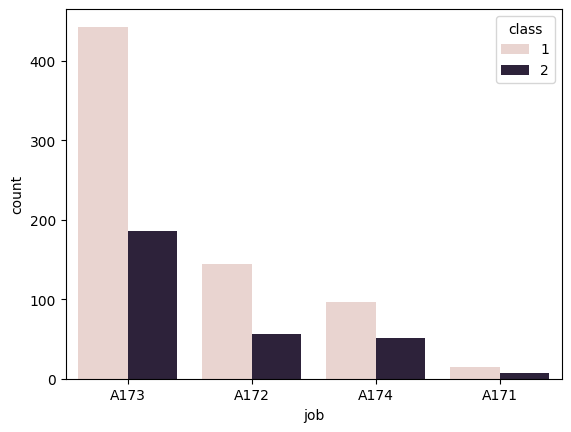

In [36]:
sns.countplot(data=df_encoded, x = 'job', hue = 'class' )

   			Job
	      A171 : unemployed/ unskilled  - non-resident
	      A172 : unskilled - resident
	      A173 : skilled employee / official
	      A174 : management/ self-employed/
		     highly qualified employee/ officer

***The distribution for each class and employment seems proportional, we can omit this category***

In [37]:
df_encoded = df_encoded.drop(columns='job', axis= 1)
df_encoded.columns

Index(['duration_month', 'credit_amount', 'present_employment',
       'disposable_income_percent', 'status_sex', 'property', 'age',
       'other_installments', 'class', 'Business', 'DomesticAppliance',
       'Education', 'FurnitureEquipment', 'NewCar', 'RadioTelevision',
       'Repairs', 'Retraining', 'UsedCar', 'Vacation', 'No_debt',
       'All_debt_paid_off_at_applying_bank', 'On_time_payments',
       'Late_payments', 'Red_Flag_Accounts', 'Great_Credit', 'Good_Credit',
       'Ok_Credit', 'Bad_Credit', 'Rent', 'Own', 'For_Free'],
      dtype='object')

<Axes: xlabel='property', ylabel='count'>

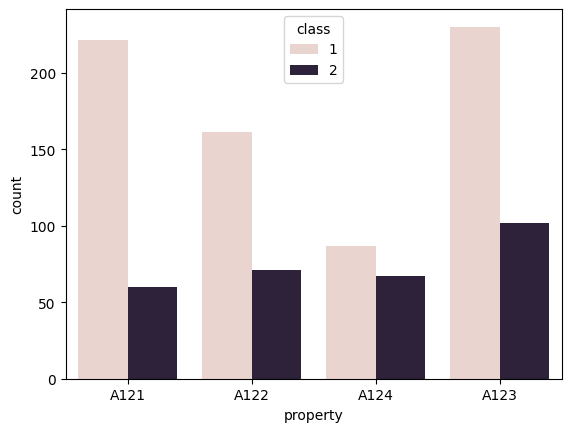

In [38]:
sns.countplot(data=df_encoded, x  = 'property', hue = 'class')

            Property
	      A121 : real_estate
	      A122 : savings_life_insurance
          A123 : Owns_Car
	      A124 : no_property

***Encoding this feature because banks tend to look at collaterals when applying for credit lines***

In [39]:
df_encoded = pd.get_dummies(df_encoded, columns=['property'], prefix='property') 

rename_dict = {
    'property_A121': 'Real_Estate',
    'property_A122': 'Savings_Life_Insurance',
    'property_A123': 'Owns_Car',
    'property_A124': 'No_Property'
}
df_encoded = df_encoded.rename(columns=rename_dict)

df_encoded.columns

Index(['duration_month', 'credit_amount', 'present_employment',
       'disposable_income_percent', 'status_sex', 'age', 'other_installments',
       'class', 'Business', 'DomesticAppliance', 'Education',
       'FurnitureEquipment', 'NewCar', 'RadioTelevision', 'Repairs',
       'Retraining', 'UsedCar', 'Vacation', 'No_debt',
       'All_debt_paid_off_at_applying_bank', 'On_time_payments',
       'Late_payments', 'Red_Flag_Accounts', 'Great_Credit', 'Good_Credit',
       'Ok_Credit', 'Bad_Credit', 'Rent', 'Own', 'For_Free', 'Real_Estate',
       'Savings_Life_Insurance', 'Owns_Car', 'No_Property'],
      dtype='object')

<Axes: xlabel='status_sex', ylabel='count'>

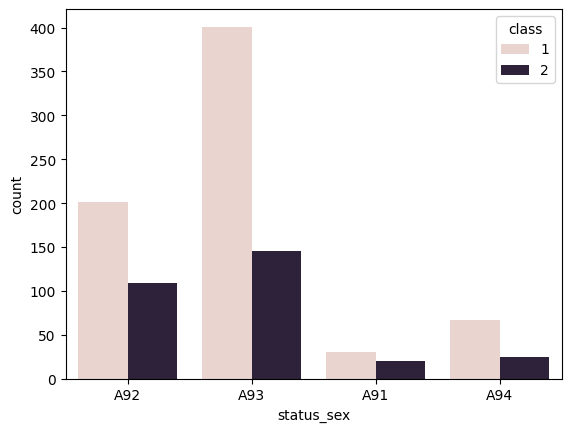

In [40]:
sns.countplot(data=df_encoded, x  = 'status_sex', hue = 'class')

	      Personal status and sex
	      A91 : male   : divorced/separated
	      A92 : female : divorced/separated/married
              A93 : male   : single
	      A94 : male   : married/widowed
	      A95 : female : single

***Encoding this feature becasue you can tell there is a difference betweeing goo/bad credit between male and females***

In [41]:
df_encoded = pd.get_dummies(df_encoded, columns=['status_sex'], prefix='status_sex') 

rename_dict = {
    'status_sex_A91': 'Male_Divorced_Separated',
    'status_sex_A92': 'Female_Divorced_Separated_Married',
    'status_sex_A93': 'Male_Single',
    'status_sex_A94': 'Male_Married_Widowed',
    # 'status_sex_A95': 'Female_Single'
}

df_encoded = df_encoded.rename(columns=rename_dict)

df_encoded.columns

Index(['duration_month', 'credit_amount', 'present_employment',
       'disposable_income_percent', 'age', 'other_installments', 'class',
       'Business', 'DomesticAppliance', 'Education', 'FurnitureEquipment',
       'NewCar', 'RadioTelevision', 'Repairs', 'Retraining', 'UsedCar',
       'Vacation', 'No_debt', 'All_debt_paid_off_at_applying_bank',
       'On_time_payments', 'Late_payments', 'Red_Flag_Accounts',
       'Great_Credit', 'Good_Credit', 'Ok_Credit', 'Bad_Credit', 'Rent', 'Own',
       'For_Free', 'Real_Estate', 'Savings_Life_Insurance', 'Owns_Car',
       'No_Property', 'Male_Divorced_Separated',
       'Female_Divorced_Separated_Married', 'Male_Single',
       'Male_Married_Widowed'],
      dtype='object')

<Axes: xlabel='present_employment', ylabel='count'>

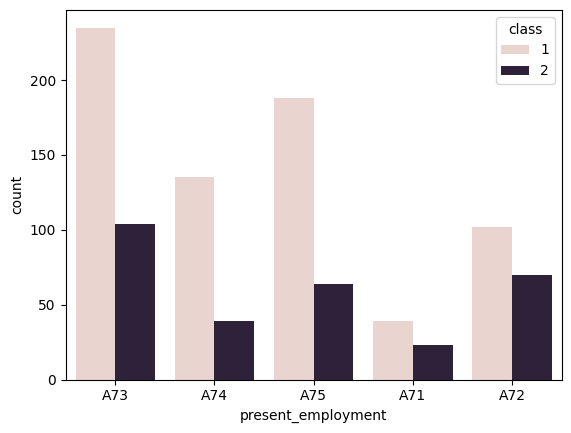

In [42]:
sns.countplot(data=df_encoded, x  = 'present_employment', hue = 'class')

      A71 : unemployed
	      A72 :       ... < 1 year
	      A73 : 1  <= ... < 4 years  
	      A74 : 4  <= ... < 7 years
	      A75 :       .. >= 7 years

***Encoding this feature becasue it is important to have a working history that is stable, it could determine you eligibility for a credit line (domain knowledge)***

In [43]:
df_encoded = pd.get_dummies(df_encoded, columns=['present_employment'], prefix='years_in employment')

rename_dict = {
    'years_in employment_A71': 'Unemployed',
    'years_in employment_A72': 'Less_than_1_year',
    'years_in employment_A73': 'Between_1_and_4_years',
    'years_in employment_A74': 'Between_4_and_7_years',
    'years_in employment_A75': 'More_than_7_years'
}
df_encoded = df_encoded.rename(columns=rename_dict)

df_encoded.columns

Index(['duration_month', 'credit_amount', 'disposable_income_percent', 'age',
       'other_installments', 'class', 'Business', 'DomesticAppliance',
       'Education', 'FurnitureEquipment', 'NewCar', 'RadioTelevision',
       'Repairs', 'Retraining', 'UsedCar', 'Vacation', 'No_debt',
       'All_debt_paid_off_at_applying_bank', 'On_time_payments',
       'Late_payments', 'Red_Flag_Accounts', 'Great_Credit', 'Good_Credit',
       'Ok_Credit', 'Bad_Credit', 'Rent', 'Own', 'For_Free', 'Real_Estate',
       'Savings_Life_Insurance', 'Owns_Car', 'No_Property',
       'Male_Divorced_Separated', 'Female_Divorced_Separated_Married',
       'Male_Single', 'Male_Married_Widowed', 'Unemployed', 'Less_than_1_year',
       'Between_1_and_4_years', 'Between_4_and_7_years', 'More_than_7_years'],
      dtype='object')

<Axes: xlabel='other_installments', ylabel='count'>

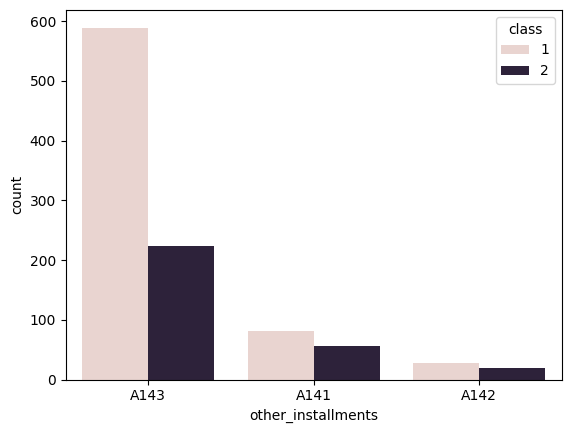

In [44]:
sns.countplot(data=df_encoded, x  = 'other_installments', hue = 'class')

     Other installment plans 
	      A141 : bank
	      A142 : stores
	      A143 : none

***Having Other Installments does not seem that affect wether you have good or bad credit,since the population results look proportional***

In [45]:
df_encoded = df_encoded.drop(columns='other_installments', axis= 1)
df_encoded.columns

Index(['duration_month', 'credit_amount', 'disposable_income_percent', 'age',
       'class', 'Business', 'DomesticAppliance', 'Education',
       'FurnitureEquipment', 'NewCar', 'RadioTelevision', 'Repairs',
       'Retraining', 'UsedCar', 'Vacation', 'No_debt',
       'All_debt_paid_off_at_applying_bank', 'On_time_payments',
       'Late_payments', 'Red_Flag_Accounts', 'Great_Credit', 'Good_Credit',
       'Ok_Credit', 'Bad_Credit', 'Rent', 'Own', 'For_Free', 'Real_Estate',
       'Savings_Life_Insurance', 'Owns_Car', 'No_Property',
       'Male_Divorced_Separated', 'Female_Divorced_Separated_Married',
       'Male_Single', 'Male_Married_Widowed', 'Unemployed', 'Less_than_1_year',
       'Between_1_and_4_years', 'Between_4_and_7_years', 'More_than_7_years'],
      dtype='object')

## Naive Bayes Algorithm With Standardization

In [46]:
x = df_encoded.drop(columns='class',axis =1)
mapping_dict = {1: 1, 2: 0}
df_encoded['class'] = df_encoded['class'].map(mapping_dict)
y = df_encoded['class']

#1 is Good, 0 is bad

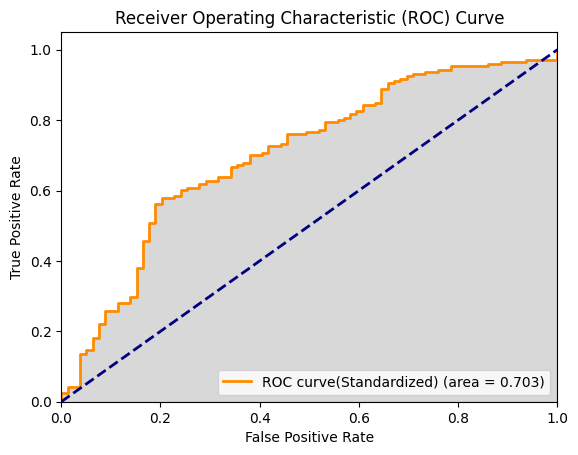

Confusion Matrix


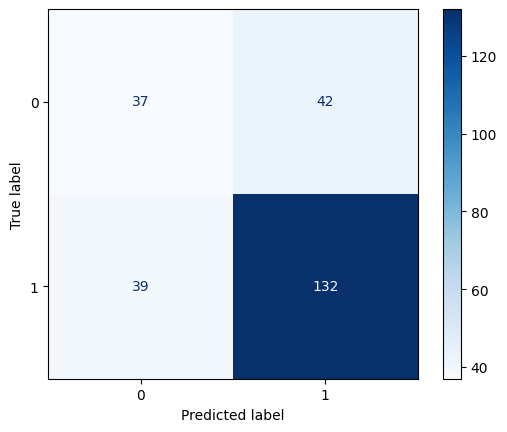

---------------------------
Performance Measures
---------------------------
Precision:, 0.7586206896551724
Recall:, 0.7719298245614035
F1 Score:, 0.7652173913043477
Accuracy Score: 0.676
-----------------------------
Hyperparameter Tuning Results
----------------------------
Best parameters:, {'var_smoothing': 0.0001}
Best score:", 0.6316420581655481


In [47]:
#Splitting
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size= .75)

#Standardizing
scaler = StandardScaler()
xtrain_scale = scaler.fit_transform(x_train)
xtest = scaler.transform(x_test)

# Hyperparameter Tuning
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]}
grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(xtrain_scale, y_train)

# Training
n_b_best = grid_search.best_estimator_
n_b_best.fit(xtrain_scale, y_train)
predictions = n_b_best.predict(xtest)

#Performance
scores = n_b_best.score(xtest, y_test)
conf_mtrx = confusion_matrix(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mtrx)

#Plotting ROC Curve
y_pred_proba = n_b_best.predict_proba(xtest)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

#Results
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve(Standardized) (area = {round(roc_auc,3)})')
plt.fill_between(fpr, tpr, color='gray', alpha=0.3) 
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show();
print('Confusion Matrix')
disp.plot(cmap='Blues', include_values=True)
plt.show();

print('---------------------------')
print('Performance Measures')
print('---------------------------')
print(f'Precision:, {precision}')
print(f'Recall:, {recall}')
print(f'F1 Score:, {f1}')
print(f'Accuracy Score: {scores}')
print('-----------------------------')
print('Hyperparameter Tuning Results')
print('----------------------------')
print(f'Best parameters:, {grid_search.best_params_}')
print(f'Best score:", {grid_search.best_score_}')

Mean Score: 0.6307079999999999


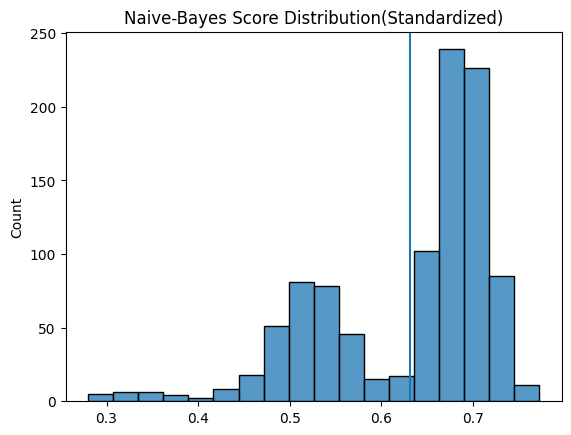

In [48]:
i = 0
n_b_score = []

while i < 1000:
    
    #Splitting
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size= .75)

    #Standardizing
    scaler = StandardScaler()
    xtrain_scale = scaler.fit_transform(x_train)
    xtest = scaler.transform(x_test)

    # Hyperparameter Tuning
    param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]}
    grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(xtrain_scale, y_train)

    # Training
    n_b_best = grid_search.best_estimator_
    n_b_best.fit(xtrain_scale, y_train)
    predictions = n_b_best.predict(xtest)

    #Performance
    scores = n_b_best.score(xtest, y_test)
    n_b_score.append(scores)
    
 

    i += 1
print(f'Mean Score: {np.mean(n_b_score)}')


sns.histplot(data=n_b_score)
plt.title('Naive-Bayes Score Distribution(Standardized)')
plt.axvline(np.mean(n_b_score))
plt.show();


## Naive Bayes Algorithm with Balanced Target and Standardized

Confusion Matrix


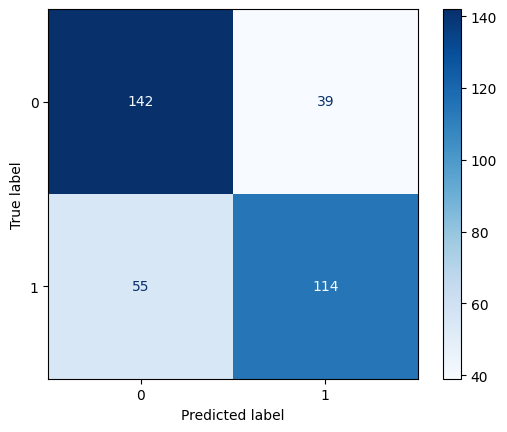

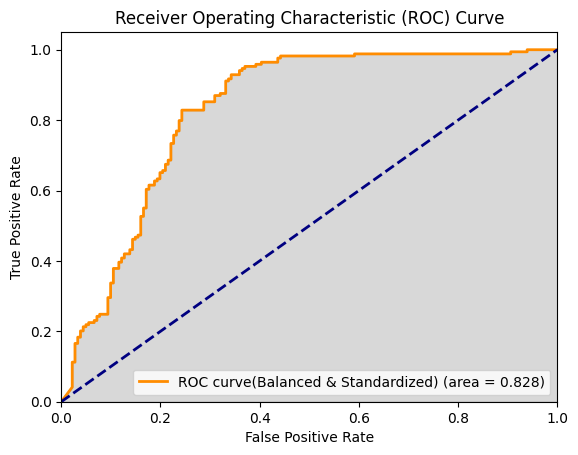

---------------------------
Performance Measures
---------------------------
Precision:, 0.7450980392156863
Recall:, 0.6745562130177515
F1 Score:, 0.7080745341614908
Accuracy Score: 0.7314285714285714
-----------------------------
Hyperparameter Tuning Results
----------------------------
Best parameters:, {'var_smoothing': 0.0001}
Best score:", 0.6832399179767601


In [49]:
#Balancing
smote = SMOTE()
X_resampled, Y_resampled =  smote.fit_resample(x,y)

#Splitting
x_train, x_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, train_size= .75)

#Standardizing
scaler = StandardScaler()
xtrain_scale = scaler.fit_transform(x_train)
xtest = scaler.transform(x_test)

# Hyperparameter Tuning
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]}
grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(xtrain_scale, y_train)

# Training
n_b_best = grid_search.best_estimator_
n_b_best.fit(xtrain_scale, y_train)
predictions= n_b_best.predict(xtest)

#Performance
scores = n_b_best.score(xtest, y_test)
conf_mtrx = confusion_matrix(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mtrx)

#Results
print('Confusion Matrix')
disp.plot(cmap='Blues', include_values=True)
plt.show();

#Plotting ROC Curve
y_pred_proba = n_b_best.predict_proba(xtest)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve(Balanced & Standardized) (area = {round(roc_auc,3)})')
plt.fill_between(fpr, tpr, color='gray', alpha=0.3) 
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show();

print('---------------------------')
print('Performance Measures')
print('---------------------------')
print(f'Precision:, {precision}')
print(f'Recall:, {recall}')
print(f'F1 Score:, {f1}')
print(f'Accuracy Score: {scores}')
print('-----------------------------')
print('Hyperparameter Tuning Results')
print('----------------------------')
print(f'Best parameters:, {grid_search.best_params_}')
print(f'Best score:", {grid_search.best_score_}')

Mean Score: 0.6989885714285714


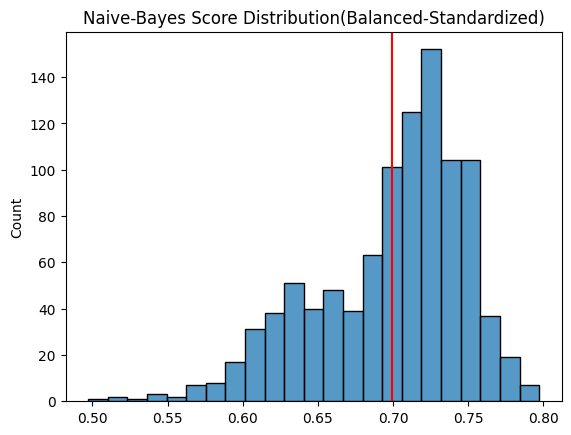

In [50]:
i = 0
n_b_score = []

while i < 1000:
    
   #Balancing
    smote = SMOTE()
    X_resampled, Y_resampled =  smote.fit_resample(x,y)
    
    #Splitting
    x_train, x_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, train_size= .75)
    
    #Standardizing
    scaler = StandardScaler()
    xtrain_scale = scaler.fit_transform(x_train)
    xtest = scaler.transform(x_test)
    
    # Hyperparameter Tuning
    param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]}
    grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(xtrain_scale, y_train)
    
    # Training
    n_b_best = grid_search.best_estimator_
    n_b_best.fit(xtrain_scale, y_train)
    predictions= n_b_best.predict(xtest)
    
    #Performance
    scores = n_b_best.score(xtest, y_test)
    n_b_score.append(scores)
    
 

    i += 1
print(f'Mean Score: {np.mean(n_b_score)}')


sns.histplot(data=n_b_score)
plt.title('Naive-Bayes Score Distribution(Balanced-Standardized)')
plt.axvline(np.mean(n_b_score), color = 'red')
plt.show();


## Without Standardization

Confusion Matrix


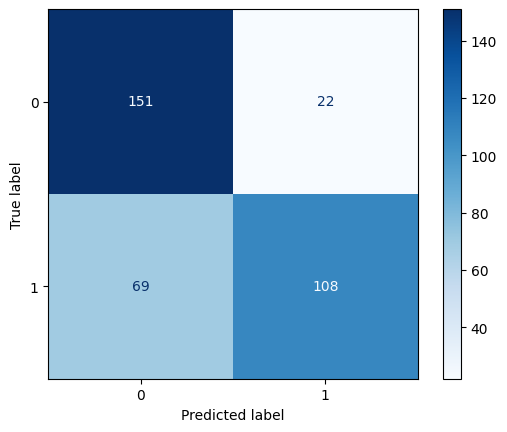

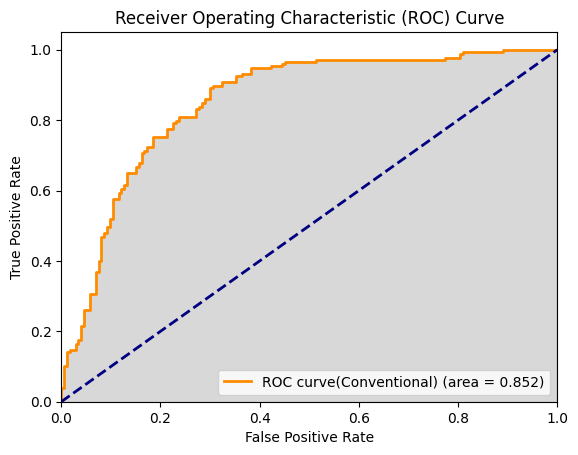

---------------------------
Performance Measures
---------------------------
Precision:, 0.8307692307692308
Recall:, 0.6101694915254238
F1 Score:, 0.7035830618892509
Accuracy Score: 0.74
-----------------------------
Hyperparameter Tuning Results
----------------------------
Best parameters:, {'var_smoothing': 1e-08}
Best score:", 0.7480382775119617


In [51]:
# Hyperparameter Tuning
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]}
grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

# Training
n_b_best = grid_search.best_estimator_
n_b_best.fit(x_train, y_train)
predictions_ = n_b_best.predict(x_test)

#Performance
scores = n_b_best.score(x_test, y_test)
conf_mtrx = confusion_matrix(y_test, predictions_)
precision = precision_score(y_test, predictions_)
recall = recall_score(y_test, predictions_)
f1 = f1_score(y_test, predictions_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mtrx)

#Results
print('Confusion Matrix')
disp.plot(cmap='Blues', include_values=True)
plt.show();


#Plotting ROC Curve
y_pred_proba = n_b_best.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve(Conventional) (area = {round(roc_auc,3)})')
plt.fill_between(fpr, tpr, color='gray', alpha=0.3) 
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show();

print('---------------------------')
print('Performance Measures')
print('---------------------------')
print(f'Precision:, {precision}')
print(f'Recall:, {recall}')
print(f'F1 Score:, {f1}')
print(f'Accuracy Score: {scores}')
print('-----------------------------')
print('Hyperparameter Tuning Results')
print('----------------------------')
print(f'Best parameters:, {grid_search.best_params_}')
print(f'Best score:", {grid_search.best_score_}')

Mean Score: 0.72132


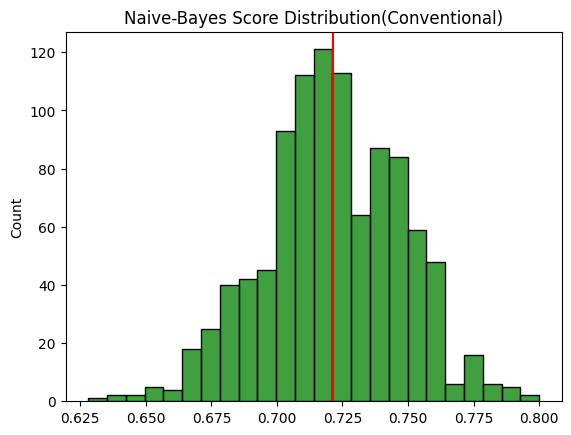

In [52]:
i = 0
n_b_score = []

while i < 1000:
    
    #Splitting
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size= .75)
    
    # Hyperparameter Tuning
    param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]}
    grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(x_train, y_train)
    
    # Training
    n_b_best = grid_search.best_estimator_
    n_b_best.fit(x_train, y_train)
    predictions= n_b_best.predict(x_test)
    
    #Performance
    scores = n_b_best.score(x_test, y_test)
    n_b_score.append(scores)
    
 

    i += 1
print(f'Mean Score: {np.mean(n_b_score)}')


sns.histplot(data=n_b_score, color='green')
plt.title('Naive-Bayes Score Distribution(Conventional)')
plt.axvline(np.mean(n_b_score), color = 'red')
plt.show();


## With Balanced Target And No Standardization

Confusion Matrix


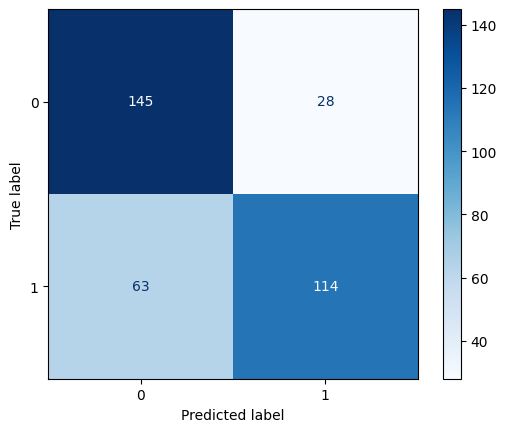

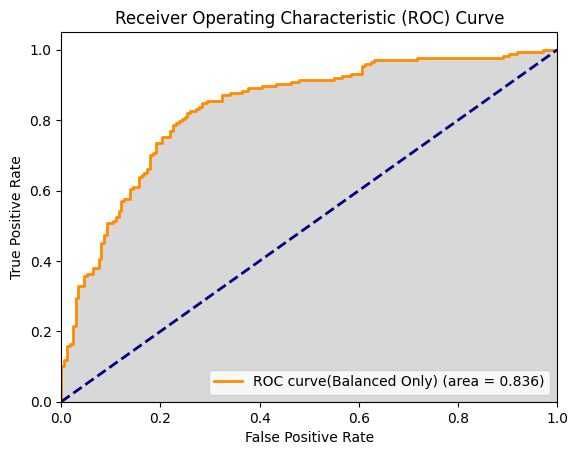

---------------------------
Performance Measures
---------------------------
Precision:, 0.8028169014084507
Recall:, 0.6440677966101694
F1 Score:, 0.7147335423197493
Accuracy Score: 0.74
-----------------------------
Hyperparameter Tuning Results
----------------------------
Best parameters:, {'var_smoothing': 1e-08}
Best score:", 0.7556892230576441


In [53]:
#Balancing
smote = SMOTE()
X_resampled, Y_resampled =  smote.fit_resample(x,y)

#Splitting
x_train, x_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, train_size= .75)

# Hyperparameter Tuning
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]}
grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

# Training
n_b_best = grid_search.best_estimator_
n_b_best.fit(x_train, y_train)
predictions_ = n_b_best.predict(x_test)

#Performance
scores = n_b_best.score(x_test, y_test)
conf_mtrx = confusion_matrix(y_test, predictions_)
precision = precision_score(y_test, predictions_)
recall = recall_score(y_test, predictions_)
f1 = f1_score(y_test, predictions_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mtrx)

#Results
print('Confusion Matrix')
disp.plot(cmap='Blues', include_values=True)
plt.show();

#Plotting ROC Curve
y_pred_proba = n_b_best.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve(Balanced Only) (area = {round(roc_auc,3)})')
plt.fill_between(fpr, tpr, color='gray', alpha=0.3) 
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show();

print('---------------------------')
print('Performance Measures')
print('---------------------------')
print(f'Precision:, {precision}')
print(f'Recall:, {recall}')
print(f'F1 Score:, {f1}')
print(f'Accuracy Score: {scores}')
print('-----------------------------')
print('Hyperparameter Tuning Results')
print('----------------------------')
print(f'Best parameters:, {grid_search.best_params_}')
print(f'Best score:", {grid_search.best_score_}')

Mean Score: 0.7475485714285715


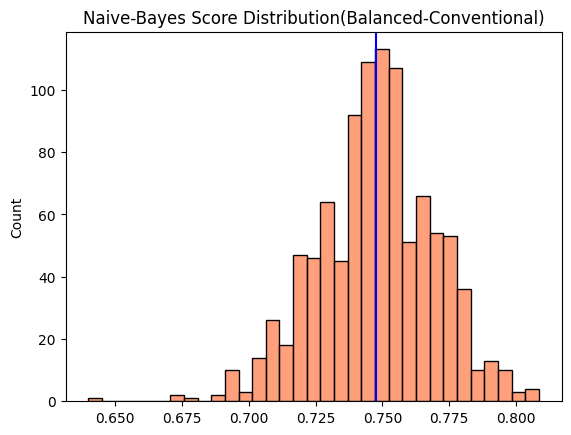

In [54]:
i = 0
n_b_score = []

while i < 1000:
    
    smote = SMOTE()
    X_resampled, Y_resampled =  smote.fit_resample(x,y)

    #Splitting
    x_train, x_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, train_size= .75)

    # Hyperparameter Tuning
    param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]}
    grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(x_train, y_train)

    # Training
    n_b_best = grid_search.best_estimator_
    n_b_best.fit(x_train, y_train)
    predictions_ = n_b_best.predict(x_test)
    
    #Performance
    scores = n_b_best.score(x_test, y_test)
    n_b_score.append(scores)
    
 

    i += 1
print(f'Mean Score: {np.mean(n_b_score)}')


sns.histplot(data=n_b_score, color='coral')
plt.title('Naive-Bayes Score Distribution(Balanced-Conventional)')
plt.axvline(np.mean(n_b_score), color = 'blue')
plt.show();


## Gradient Boosting Machines 
### With Balanced Target And No Standardization

Confusion Matrix


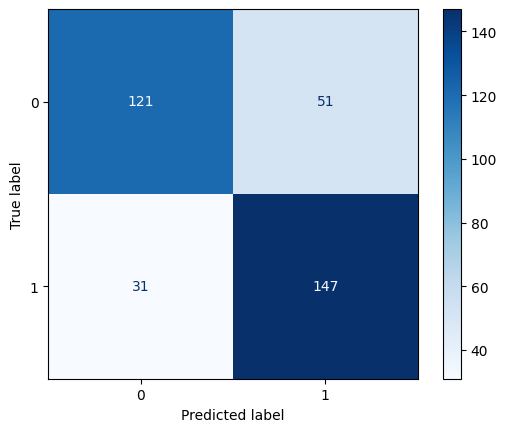

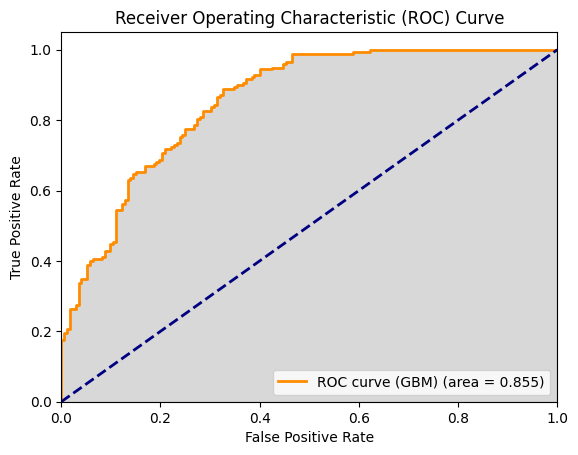

---------------------------
Performance Measures
---------------------------
Precision: 0.7424242424242424
Recall: 0.8258426966292135
F1 Score: 0.7819148936170214
Accuracy Score: 0.7657142857142857
-----------------------------
Hyperparameter Tuning Results
----------------------------
Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
Best score: 0.8072499430394167


In [55]:
# Balancing
smote = SMOTE()
X_resampled, Y_resampled = smote.fit_resample(x, y)

# Splitting
x_train, x_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, train_size=0.75)

# Hyperparameter Tuning for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages to be run
    'learning_rate': [0.01, 0.1, 0.2],  # Shrinks the contribution of each tree by learning_rate
    'max_depth': [3, 4, 5]  # Maximum depth of the individual regression estimators
}
grid_search = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

# Training with the best parameters found
gbm_best = grid_search.best_estimator_
gbm_best.fit(x_train, y_train)
predictions = gbm_best.predict(x_test)

# Performance evaluation
scores = gbm_best.score(x_test, y_test)
conf_mtrx = confusion_matrix(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# Confusion Matrix Display
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mtrx)
print('Confusion Matrix')
disp.plot(cmap='Blues', include_values=True)
plt.show()

# Plotting ROC Curve
y_pred_proba = gbm_best.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (GBM) (area = {round(roc_auc, 3)})')
plt.fill_between(fpr, tpr, color='gray', alpha=0.3)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print('---------------------------')
print('Performance Measures')
print('---------------------------')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Accuracy Score: {scores}')
print('-----------------------------')
print('Hyperparameter Tuning Results')
print('----------------------------')
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

In [ ]:
# Parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],  
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4]
}


n_iterations = 1000 

accuracy_scores = []

for i in range(n_iterations):
    
    # Balancing with SMOTE
    smote = SMOTE()
    X_resampled, Y_resampled = smote.fit_resample(x, y)
    
    # Splitting the data
    x_train, x_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, train_size=0.75)
    
    # Hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(x_train, y_train)
    
    # Training the model with the best found parameters
    gbm_best = grid_search.best_estimator_
    gbm_best.fit(x_train, y_train)
    predictions = gbm_best.predict(x_test)
    
    # Evaluating the model
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores.append(accuracy)

# Display overall evaluation results
mean_accuracy = np.mean(accuracy_scores)
std_dev_accuracy = np.std(accuracy_scores)

# Display the histogram of accuracy scores
sns.histplot(data=accuracy_scores, color='coral', kde=True)  # KDE=True adds a curve that estimates the distribution
plt.title('GBM Score Distribution (Balanced-Resampled)')
plt.axvline(mean_accuracy, color='blue', label=f'Mean Accuracy: {mean_accuracy:.4f}')
plt.legend()
plt.show()

print('---------------------------')
print('Robust Evaluation Results')
print('---------------------------')
print(f'Mean Accuracy: {mean_accuracy:.4f}')
print(f'Standard Deviation of Accuracy: {std_dev_accuracy:.4f}')
